<div style="display: flex; justify-content: space-between; align-items: center;">
  <span>📅 15/10/2025</span>
    <p align="right">
    <a href="https://colab.research.google.com/github/tripathysagar/NanoTransformer/blob/main/nbs/01_GPTText2Text.ipynb" target="_blank">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    </p>
</div>

## Introduction & Motivation


**Aim**: This blog documents the implementation of a Transformer architecture, focusing on the pretraining process that is critical and foundational to all LLMs. We use Shakespeare's text as our dataset, keeping the setup lightweight enough to run on a single GPU in Google Colab's free tier.

**Transformers**: These are the neural network architecture powering modern language models. Originally introduced in the paper *"Attention is All You Need"* (Vaswani et al., 2017), transformers have become the foundation for models like GPT, BERT, and beyond.


**Note on Scope:** This blog focuses exclusively on the **pre-training** phase of language models—teaching a transformer to predict the next character in a sequence. It does not covers the additional steps that make models like ChatGPT conversational and helpful, such as:

- Supervised Fine-Tuning (SFT) - teaching the model to follow instructions
- Reinforcement Learning from Human Feedback (RLHF) - aligning the model with human preferences

Think of this as "GPT" without the "Chat"—we're building the foundational language understanding, which is the critical first step that all modern LLMs go through.

## Dataset & Preprocessing

A language model learns the joint probability distribution of words in a sentence—which is just a fancy way of saying it learns to predict the next word. For this step, big labs scrape massive amounts of text from the web and feed it to their models to learn from. There are big dataset like *FineWeb edu* or *common crawl* data. As I am extremely GPU poor, we will consider the Shakespeare dataset i.e. some of the literature he produced. The data set is taken from the legendary *Karpathy's Nanogpt* series. In fact this blog is a technical write up for the educational [Zero to hero](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ) created by him.

The dataset consists of a giant text file, a big file dump. With all the text concatenated. Shakespeare dataset has about 1.1 million characters and 200k words—a nice manageable size for a toy transformer! 

The dataset is devided by `90:10` ratio for training and valid respectively. Below is a example of dataset creation.

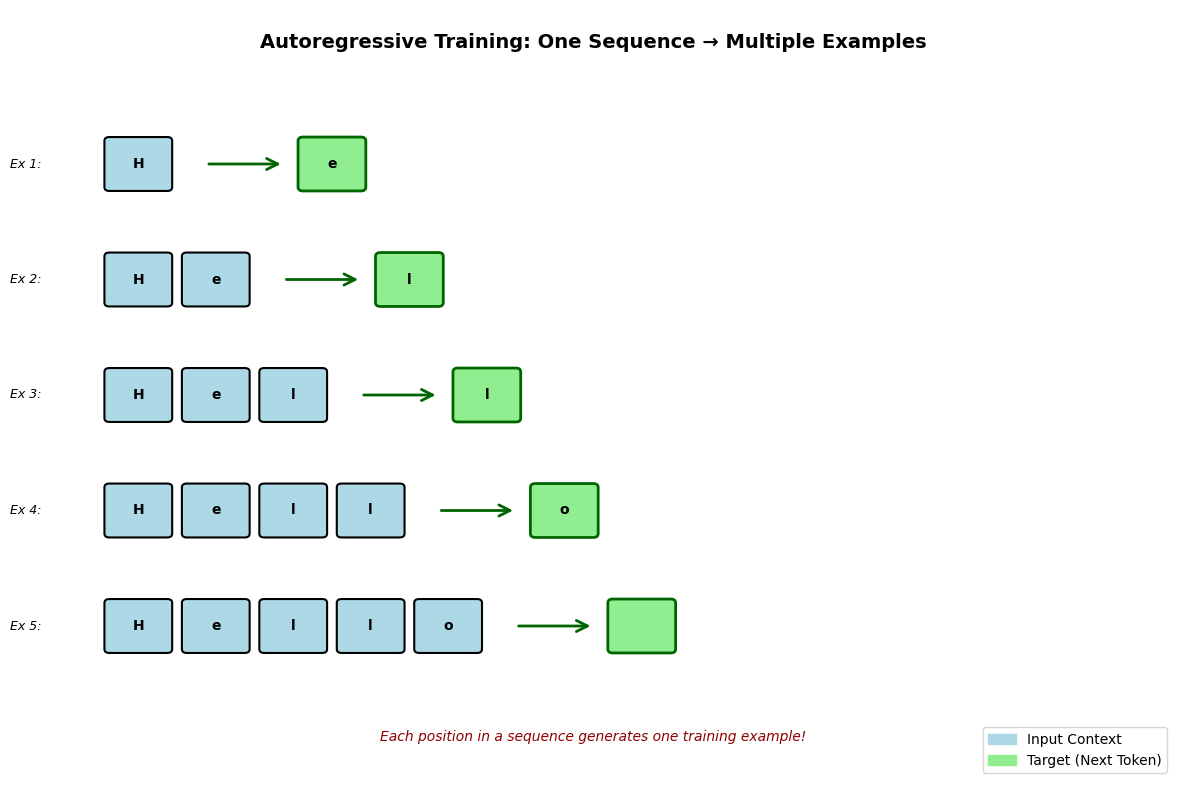

In [ ]:
#|echo: false
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 12)
ax.set_ylim(0, 10)
ax.axis('off')

# Title
ax.text(6, 9.5, 'Autoregressive Training: One Sequence → Multiple Examples', 
        ha='center', fontsize=14, weight='bold')

# Example sequence
sequence = "Hello world"
tokens = list(sequence)

# Draw training examples
y_positions = [8, 6.5, 5, 3.5, 2]
num_examples = 5

for idx in range(num_examples):
    y = y_positions[idx]
    
    # Input tokens
    x_start = 1
    for i in range(idx + 1):
        box = FancyBboxPatch((x_start, y-0.3), 0.6, 0.6, 
                            boxstyle="round,pad=0.05",
                            edgecolor='black', facecolor='lightblue', linewidth=1.5)
        ax.add_patch(box)
        ax.text(x_start + 0.3, y, tokens[i], ha='center', va='center', 
               fontsize=10, weight='bold')
        x_start += 0.8
    
    # Arrow
    ax.add_patch(FancyArrowPatch((x_start + 0.2, y), (x_start + 1, y),
                                arrowstyle='->', mutation_scale=20, 
                                linewidth=2, color='darkgreen'))
    
    # Target token
    target_box = FancyBboxPatch((x_start + 1.2, y-0.3), 0.6, 0.6,
                               boxstyle="round,pad=0.05",
                               edgecolor='darkgreen', facecolor='lightgreen', 
                               linewidth=2)
    ax.add_patch(target_box)
    ax.text(x_start + 1.5, y, tokens[idx + 1], ha='center', va='center',
           fontsize=10, weight='bold')
    
    # Label
    ax.text(0.3, y, f'Ex {idx+1}:', ha='right', va='center', 
           fontsize=9, style='italic')

# Legend
input_patch = mpatches.Patch(color='lightblue', label='Input Context')
target_patch = mpatches.Patch(color='lightgreen', label='Target (Next Token)')
ax.legend(handles=[input_patch, target_patch], loc='lower right', fontsize=10)

# Note
ax.text(6, 0.5, 'Each position in a sequence generates one training example!', 
        ha='center', fontsize=10, style='italic', color='darkred')

plt.tight_layout()
plt.show()

For the string "Hello", here's how the autoregressive training creates examples:

**Independent variable (Input/Context)**: The sequence of characters seen so far
**Dependent variable (Target/Output)**: The next character to predict

Lets consider examples from "Hello" which generates 4 training sample :

1. Input: "H" → Target: "e"
2. Input: "He" → Target: "l"  
3. Input: "Hel" → Target: "l"
4. Input: "Hell" → Target: "o"

Each example uses the previous characters (independent variable) to predict the next one (dependent variable).

## Tokenization

Any process involving languages goes through the **Tokenization** step. It's basically the art of breaking text into smaller chunks that the model can work with. There are many ways to achieve this:

- **Character-level**: Split into individual characters
- **Word-level**: Split by words
- **Subword-level**: Split into meaningful chunks (BPE, WordPiece, etc.)
- **Byte-level**: Split into bytes (used in GPT-2)

This implementation used **Character-level**. By using character-level tokenization, we keep things simple and lightweight. Since we're modeling at the character level, the **vocab** (vocabulary—the set of all possible tokens our model knows about)  of our model is all the unique chars present in the text. There are around 65 unique chars in the dataset. Reasons for choosing this approach: simpler to implement, good for learning, and Shakespeare has a manageable vocab size.

## Embedding

### Token Embeddings
Embeddings are the individual vector representations we learn for each token in our vocabulary. This converts each token (character, in our case) into a multi-dimensional vector—typically something like 64, 128, or 512 numbers—that captures relationships between tokens. The model learns these vectors during training. Larger embedding dimensions lead to stronger learning of these patterns. For example, 'a' and 'e' might be used in similar contexts (both are vowels), so their embeddings become similar. These embeddings start as random numbers, and through training, the model gradually adjusts them to find optimal values that capture meaningful patterns. For the given itration of the expreiment, embedding dimensions is set to `128`.

![](./static/blog5/token_embeddings.png)


### Positional Embeddings

Once a sentence is converted to a list of tokens, these tokens are position invariant i.e. are not aware what comes after what. positional embedding helps us in learning that. The positional embedding matrix has dimensions *seq_len* × *embedding_dim*, where each position gets its own vector that's added to the token embedding. The sequence length (also called context length) is the window of text the model can 'remember' at once when predicting the next character. 
There are two main approaches:
- Learned positional embeddings: Start random and are trained alongside the model (used in GPT)
- Fixed sinusoidal embeddings: Use sine/cosine functions, not trainable (original Transformer paper)

We use learned positional embeddings—these start as random values and get optimized during training, just like the token embeddings. The context length is set to `128`. The input to the model `input = token_embedding + positional_embedding`. We add them (rather than concatenate) so the input stays compact and the model learns to blend what and where information together.

![](./static/blog5/postional_encoding.png)



![Input to attention block.](./static/blog5/input2attn.png)


## Causal Self Attention

**Attention**: After embedding the inputs, the model needs to learn which previous tokens are most relevant for predicting the next one. For example, in 'Hello, my name is S____', the model should pay attention to the broader context, not just the immediate previous character. The mechanism for building attention is to project the input into three different representations: **Key (K)**, **Query (Q)**, and **Value (V)**. These are learned linear projections (just matrix multiplications that the model learns) of the input—in our case. While our embeddings are 128 dimensions, we project Q, K, V down to 16 dimensions each for this attention head. Below is a mental model for the idea behind them with respect to databases:

1. **Key (K)**: Index or primary key of a table
2. **Query (Q)**: User asking questions
3. **Value (V)**: Answer to the user's query
   

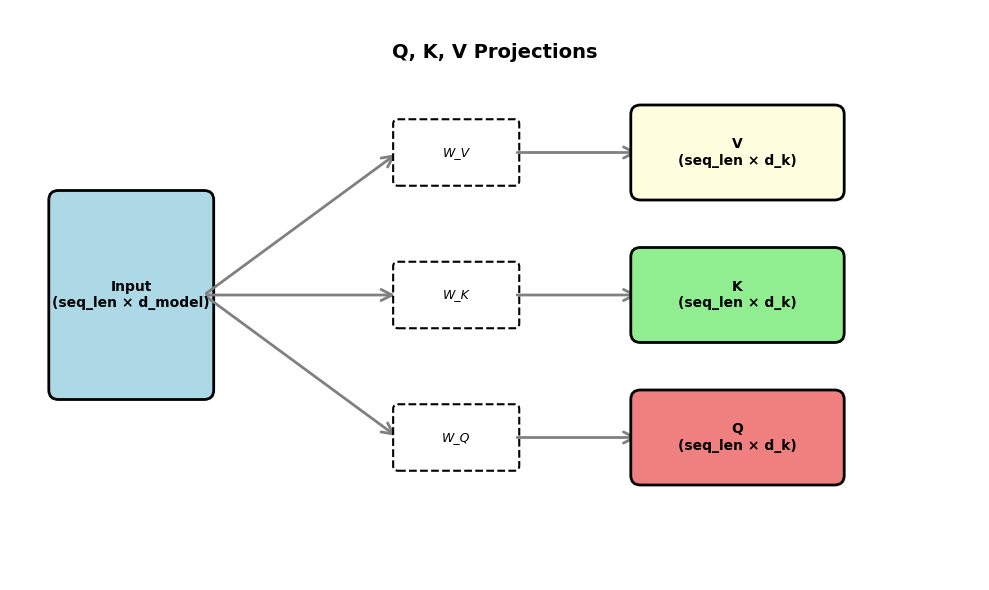

In [ ]:
#|echo: false
# Visualization 1: Q, K, V Projections (unchanged)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.axis('off')

# Input
input_box = FancyBboxPatch((0.5, 2), 1.5, 2, boxstyle="round,pad=0.1", 
                           edgecolor='black', facecolor='lightblue', linewidth=2)
ax.add_patch(input_box)
ax.text(1.25, 3, 'Input\n(seq_len × d_model)', ha='center', va='center', fontsize=10, weight='bold')

# Q, K, V boxes
colors = ['lightcoral', 'lightgreen', 'lightyellow']
labels = ['Q', 'K', 'V']
positions = [1.5, 3, 4.5]

for label, color, ypos in zip(labels, colors, positions):
    # Arrow and weight
    ax.add_patch(FancyArrowPatch((2, 3), (4, ypos), arrowstyle='->', 
                                mutation_scale=20, linewidth=2, color='gray'))
    ax.add_patch(FancyBboxPatch((4, ypos-0.3), 1.2, 0.6, boxstyle="round,pad=0.05",
                               edgecolor='black', facecolor='white', linewidth=1.5, linestyle='--'))
    ax.text(4.6, ypos, f'W_{label}', ha='center', va='center', fontsize=9, style='italic')
    
    # Output
    ax.add_patch(FancyArrowPatch((5.2, ypos), (6.5, ypos), arrowstyle='->', 
                                mutation_scale=20, linewidth=2, color='gray'))
    ax.add_patch(FancyBboxPatch((6.5, ypos-0.4), 2, 0.8, boxstyle="round,pad=0.1",
                               edgecolor='black', facecolor=color, linewidth=2))
    ax.text(7.5, ypos, f'{label}\n(seq_len × d_k)', ha='center', va='center', fontsize=10, weight='bold')

ax.text(5, 5.5, 'Q, K, V Projections', ha='center', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

Just like a database query finds relevant records, the Query helps find which tokens in our sequence are most relevant to the current position. The model compares each Query against all Keys to compute attention scores, which determine how much each token should attend to every other token. These scores are then used to create a weighted sum of the Values.

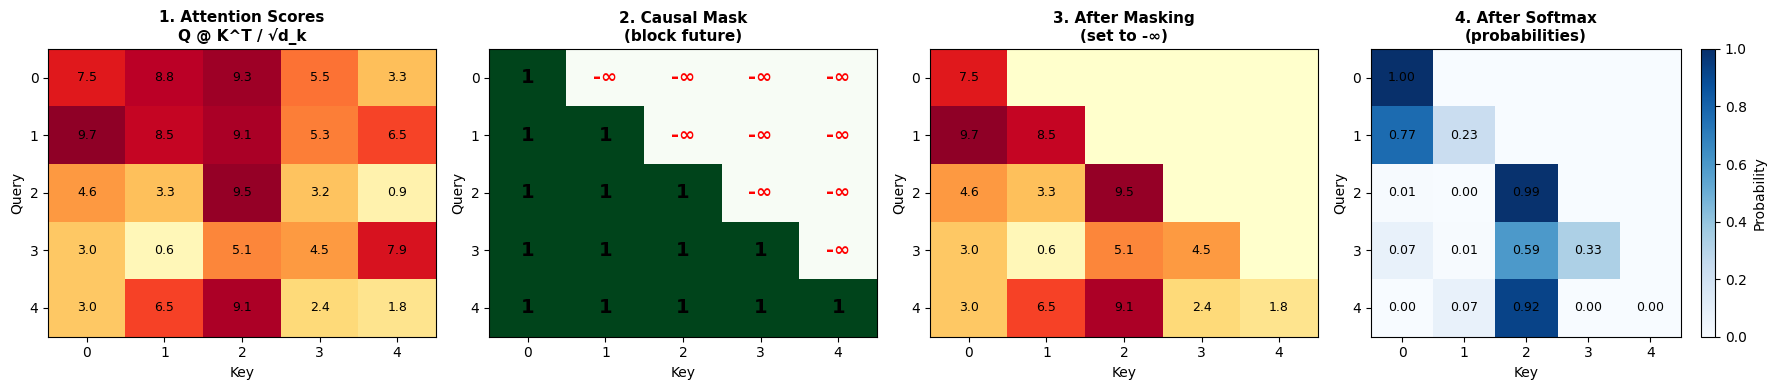

In [ ]:
#|echo: false
import numpy as np
# Visualization 2: Causal Mask with Softmax
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

seq_len = 5
attn_scores = np.random.rand(seq_len, seq_len) * 10

# Apply causal mask
masked_attn = attn_scores.copy()
masked_attn[np.triu_indices(seq_len, k=1)] = -np.inf

# Apply softmax row-wise
softmax_attn = np.exp(masked_attn - np.max(masked_attn, axis=1, keepdims=True))
softmax_attn = softmax_attn / np.sum(softmax_attn, axis=1, keepdims=True)

# Plot 1: Attention scores
im1 = axes[0].imshow(attn_scores, cmap='YlOrRd', aspect='auto', vmin=0, vmax=10)
axes[0].set_title('1. Attention Scores\nQ @ K^T / √d_k', weight='bold', fontsize=11)
axes[0].set_xlabel('Key')
axes[0].set_ylabel('Query')
for i in range(seq_len):
    for j in range(seq_len):
        axes[0].text(j, i, f'{attn_scores[i,j]:.1f}', ha='center', va='center', fontsize=9)

# Plot 2: Causal mask
mask_vis = np.tril(np.ones((seq_len, seq_len)))
axes[1].imshow(mask_vis, cmap='Greens', aspect='auto', vmin=0, vmax=1)
axes[1].set_title('2. Causal Mask\n(block future)', weight='bold', fontsize=11)
axes[1].set_xlabel('Key')
axes[1].set_ylabel('Query')
for i in range(seq_len):
    for j in range(seq_len):
        text = '1' if j <= i else '-∞'
        color = 'black' if j <= i else 'red'
        axes[1].text(j, i, text, ha='center', va='center', fontsize=14, color=color, weight='bold')

# Plot 3: After masking
masked_display = attn_scores.copy()
masked_display[np.triu_indices(seq_len, k=1)] = 0
im3 = axes[2].imshow(masked_display, cmap='YlOrRd', aspect='auto', vmin=0, vmax=10)
axes[2].set_title('3. After Masking\n(set to -∞)', weight='bold', fontsize=11)
axes[2].set_xlabel('Key')
axes[2].set_ylabel('Query')
for i in range(seq_len):
    for j in range(seq_len):
        if j <= i:
            axes[2].text(j, i, f'{attn_scores[i,j]:.1f}', ha='center', va='center', fontsize=9)

# Plot 4: After softmax
im4 = axes[3].imshow(softmax_attn, cmap='Blues', aspect='auto', vmin=0, vmax=1)
axes[3].set_title('4. After Softmax\n(probabilities)', weight='bold', fontsize=11)
axes[3].set_xlabel('Key')
axes[3].set_ylabel('Query')
for i in range(seq_len):
    for j in range(seq_len):
        if j <= i:
            axes[3].text(j, i, f'{softmax_attn[i,j]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im4, ax=axes[3], label='Probability')

plt.tight_layout()
plt.show()

```py
class AttentionHead(nn.Module):
    def __init__(self, config:GPTConfig):
        super().__init__()
        assert config.embedding_dim % config.n_heads == 0
        self.head_dim = config.embedding_dim // config.n_heads

        self.Q_W = nn.Linear(config.embedding_dim, self.head_dim)       # weight of Q
        self.K_W = nn.Linear(config.embedding_dim, self.head_dim)       # weight of K
        self.V_W = nn.Linear(config.embedding_dim, self.head_dim)       # weight of V

        mask = torch.tril(torch.ones(config.seq_len, config.seq_len))
        self.register_buffer('mask', mask.masked_fill(mask == 0, float('-inf'))) # for building Causal mask

        self.dropout = nn.Dropout(p = config.dropout)                    # randomly switching off some logits

    def forward(self, x): #bs * seq_len * embedding_dim
        Q, K, V = self.Q_W(x), self.K_W(x), self.V_W(x)                #bs * seq_len * head_dim
        
        attn = Q @ K.transpose(-2, -1) /  self.head_dim ** 0.5         #bs * seq_len * head_dim @ bs * head_dim * seq_len -> bs * seq_len * seq_len
        attn += self.mask[:x.shape[1], :x.shape[1]]

        attn = torch.softmax(attn, dim=-1)
        return self.dropout(attn @ V)                                  # bs * seq_len * seq_len @ bs * seq_len * head_dim -> bs * seq_len *  head_dim
```

## Multi-head attention 



A multi-head attention block runs multiple attention heads in parallel. Here's what multi-head attention typically achieves:
- **Diversity**: Each head can learn to attend to different patterns (one might focus on nearby characters, another on longer-range dependencies)
- **Richer representation**: Combining multiple heads gives a more complete picture than a single attention mechanism

The outputs of all attention heads are concatenated together. Since each head outputs 16 dimensions and we have 8 heads, the concatenated result is back to our original 128 dimensions (8 × 16 = 128). This combined output is then fed through a final linear layer to mix the information from all the different attention perspectives. In the current setup, the number of heads is **8** (embedding_dim / head_dim = 128/16).


![Multi Attention Head.](./static/blog5/MHA.png)



```py
class MultiHeadAttention(nn.Module):
    def __init__(self, config:GPTConfig):
        super().__init__()
        assert config.embedding_dim % config.n_heads == 0 # config.n_heads * output of the embedding layer

        self.heads = nn.ModuleList([AttentionHead(config) for _ in range(config.n_heads)])
        self.dropout = nn.Dropout(p=config.dropout)
        self.linear = nn.Linear(config.embedding_dim, config.embedding_dim)
        self.layer_norm = nn.LayerNorm(config.embedding_dim)

    def forward(self, x): #bs * seq_len * embedding_dim
        head = torch.cat([head(x) for head in self.heads], dim=-1) #bs * seq_len * embedding_dim
        head = self.dropout(self.linear(head))                     #bs * seq_len * embedding_dim
        return self.layer_norm(head + x)                           #residual connections
```
Note:
1. **LayerNorm**: A normalization technique that normalizes activations across the feature dimension, stabilizing training and helping gradients flow better.
1. **Resblock**: allow gradients to flow directly backward through the network, which is crucial for training deep models. Without them, gradients can vanish during backpropagation.

## Feed-forward network

The output from multi-head attention is passed through a feed-forward network. After attention determines *which* tokens are relevant, the FFN processes and transforms that information at each position independently. 

The FFN typically:
- **Expands** the representation to a larger dimension (e.g., 128 → 512), giving the model more capacity to learn complex patterns
- Applies a **non-linear activation** function (like GELU or ReLU) to capture non-linear relationships. Which is a key aspect of any **Nural network**.
- **Projects back** to the original dimension (512 → 128). The output is of dim embedding_dim.

This expansion and contraction, combined with the non-linearity, allows the model to learn richer transformations of the attended features.
```py
class FFN(nn.Module):
    def __init__(self, config:GPTConfig):
        super().__init__()

        self.dropout = nn.Dropout(p=config.dropout)
        self.linear1 = nn.Linear(config.embedding_dim, 4 * config.embedding_dim)
        self.linear2 = nn.Linear(4 *config.embedding_dim, config.embedding_dim)
        self.layer_norm = nn.LayerNorm(config.embedding_dim)
        self.gelu = nn.GELU(approximate='tanh')

    def forward(self, x): #bs * seq_len * embedding_dim
        pred = self.linear2(self.gelu(self.linear1(x)))
        return self.layer_norm(self.dropout(pred) + x)
```

The transformer architecture is built by stacking multiple layers of these MHA → FFN blocks. Each layer (or "transformer block") gets progressively better at understanding the input. Below is a rough struct.


- Input → Embedding
- Transformer Block 1 (MHA → FFN)
- Transformer Block 2 (MHA → FFN)
- Transformer Block 3 (MHA → FFN)
- ... (repeat N times)
- Final output layer

More depth allows the model to learn more complex patterns in the text, but requires more compute resources and training time. In our setup, we use **[N]** transformer blocks.

**Single block:**


![](./static/blog5/Single_block.png)

## Language Head
It takes in the output of the final attention meachanisim and return output of **batch_size × seq_len × vocab_size**. From where model can make predictions of next vocab using a single linear layer that projects from **embedding_dim → vocab_size**. Each vocab has a logits or probability distribution.

```py
self.lm_head = nn.Linear(config.embedding_dim, config.vocab_size)
```

## Complete model:
![](./static/blog5/Finale_gpt_model.png)

## Now comes the fun part—teaching our model to actually speak Shakespeare!

To train our model, we need a **loss function** a way to measure how wrong our predictions are. For language modeling **Cross-entropy** used  which measures how far our predicted probability distribution is from the actual next character. If the actual next character is 'e' and our model gives it a 90% probability, that's great! But if it only gives 'e' a 5% probability, the cross-entropy loss will be high, signaling the model needs to improve.

**Hyperparameters**

| Parameter | Value | Description |
|-----------|-------|-------------|
| **Batch Size** | 256 | Number of sequences processed in parallel |
| **Sequence Length** | 128 | Context window (max tokens the model can see) |
| **Embedding Dimension** | 128 | Size of token/positional embeddings |
| **Number of Layers** | 4 | Transformer blocks stacked |
| **Number of Heads** | 8 | Attention heads per block |
| **Vocabulary Size** | 65 | Total unique characters in dataset |
| **Dropout** | 0.1 | Dropout probability for regularization |
| **Learning Rate** | 1e-3 | Fixed learning rate for Adam optimizer |
| **Max Gradient Norm** | 1.0 | Gradient clipping threshold |
| **Device** | CUDA/CPU | Automatic GPU detection |
| **Dtype** | bfloat16/float16 | Mixed precision training |
| **epochs** | 75 | No of steps the training is done |



**Training setup**: I used the Adam optimizer with a fixed learning rate of 1e-3 and trained for 75 epochs. On Colab's free tier GPU, this took a while (grab a coffee!), but it's totally doable without fancy hardware.

## Generation (Inference)

Now that our model is trained, let's make it generate some Shakespeare! The function takes a prompt (like "To be or not to be") and predicts characters one at a time.

**Key parameters:**
- **max_new_tokens**: How many new characters to generate
- **temperature**: Controls randomness. Higher values (like 1.5) make it more creative/chaotic, lower values (like 0.5) make it more predictable and coherent

**How it works:**
1. Start with your prompt, convert it to tokens
2. Feed it through the model to get predictions for the next character
3. Sample a character based on those predictions (with some randomness controlled by temperature)
4. Add that character to the sequence and repeat

The model keeps the conversation going character by character until it hits the max_new_tokens limit. It's autoregressive—each new prediction depends on everything that came before!


```py
@torch.no_grad() 
def generate(prompt, max_new_tokens=100, temperature=1.0):
    """
    prompt: string to start generation
    max_new_tokens: how many tokens to generate
    temperature: higher = more random, lower = more deterministic
    """
    model.eval()
    tokens = tokenizer.encode(prompt)
    tokens = torch.tensor(tokens).unsqueeze(0)  # Add batch dim
    tokens = tokens.to('cuda')
    for _ in range(max_new_tokens):
        # Crop to last seq_len tokens if needed
        context = tokens if tokens.size(1) <= model.embed.pos_ids.size(0) else tokens[:, -model.embed.pos_ids.size(0):]

        # Get predictions
        with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.bfloat16):
          logits = model(context)
        logits = logits[:, -1, :] / temperature  # Focus on last token

        # Sample next token
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        # Append to sequence
        tokens = torch.cat([tokens, next_token], dim=1)

    return tokenizer.decode(tokens.squeeze().tolist())
print(generate("To be or not to be"))
```


## Conclusion

This project successfully implemented a character-level transformer model trained on Shakespeare's text. The model learned to generate coherent, Shakespeare-style text by predicting characters one at a time. The model demonstrates the power of the transformer architecture even in a resource-constrained setting (single GPU on Colab's free tier).

**What worked well:**
- The attention mechanism effectively captured dependencies between characters
- Character-level tokenization kept the vocabulary small (65 tokens) and manageable
- The model converged and produced recognizable Shakespeare-style patterns

**Areas for improvement:**

Several optimization techniques were not implemented in this version but could significantly improve performance:



1. **Proper weight initialization**: The layers were not initialized optimally, which may have slowed convergence and required more training epochs.
2. **Learning rate scheduling**: A fixed learning rate was used throughout training. Implementing a learning rate schedule (such as cosine decay or warmup followed by decay) would allow the model to take larger steps early in training and fine-tune more carefully later.
3. **Regularization**: Weight decay in the Adam optimizer was not properly tuned, which could help prevent overfitting and improve generalization.

**Next steps:**

Future iterations could explore more advanced techniques used in modern language models:


- **RoPE (Rotary Position Encoding)**: A more effective positional encoding scheme used in models like LLaMA
- **Grouped Query Attention (GQA)**: An efficient attention variant that reduces memory usage while maintaining performance
- **Flash Attention**: Optimized attention implementation for faster training
- **Multimodal training**: Extending beyond text to handle multiple data types

This project serves as a solid foundation for understanding how transformers work under the hood and provides a stepping stone toward implementing more sophisticated architectures.

## Reference
1. **Attention is All You Need** - The original transformer paper [Vaswani et al., 2017](https://arxiv.org/pdf/1706.03762)
1. **Andrej Karpathy's "Let's build GPT"** - The video tutorial you followed
1. **Shakespeare** [dataset](https://github.com/karpathy/build-nanogpt) 
1. **GPT2 paper**: [Improving Language Understanding by Generative Pre-Training](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf)